# Import des packages nécessaires

In [1]:
import pandas as pd
import numpy as np

# Récupération des fonctions des autres notebooks

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1913/3381651992.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("DataSets/ODD_DEP.csv",sep=';',encoding_errors='ignore')


Nom du département (avec majuscule)d


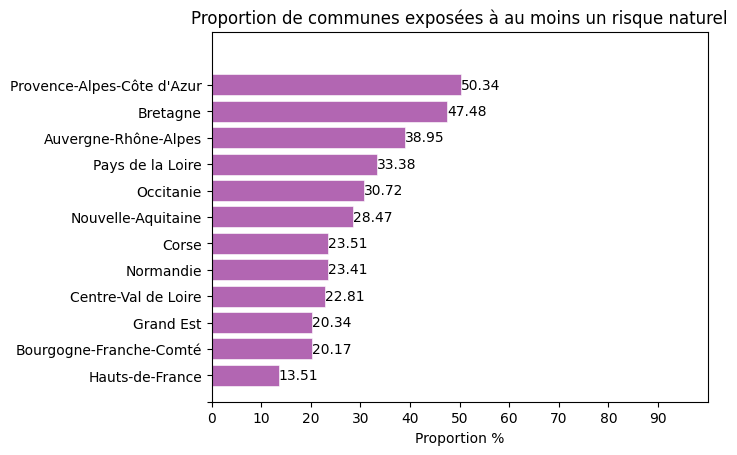

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (0,).

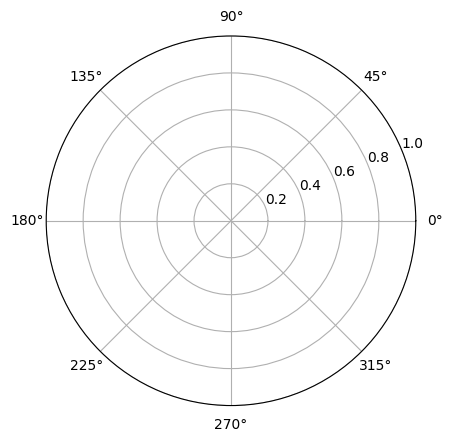

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (0,).

In [1]:
#%run INSEE.ipynb #fonctionne
%run Nucléaire.ipynb #fonctionne mais faut vraiment faire un truc pour qu'il trouve l'addresse plus facilement
%run get_risque_glissement_terrain.ipynb #fonctionne
#%run Stats_Nucleaire.ipynb #checked et marche bien
%run get_risque_inondations.ipynb #Marche bien maintenant
%run get_secheresse.ipynb #Marche bien
%run Secheresse.ipynb #manque le /content

In [ ]:
def final_score(dep, num, nom_voie, ville, code_postal):
    